In [1]:
using Pkg
Pkg.activate(".")
using DataFrames, CSV, HypothesisTests, Glob, Dates, Turing, StatsPlots, StatsBase
include("Utils.jl")


  Activating project at `~/BayesCSF`


curve_fitting (generic function with 4 methods)

NRMSE (GD) = 0.126 IQR: 0.108
NRMSE (Bayes) = 0.124 IQR: 0.107
W = 305408.5, p-value = 0.06128974748528598, n = 1128
Difference insignificant


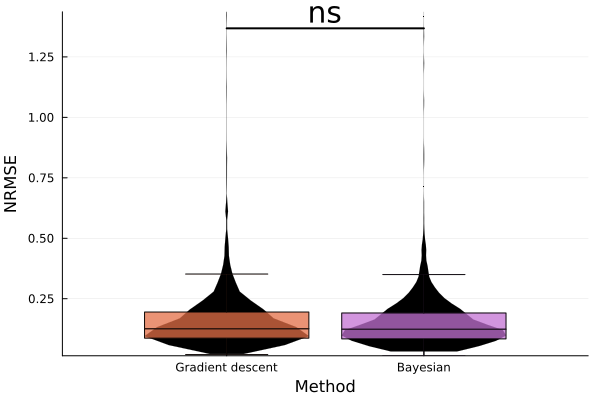

In [145]:
df = DataFrame(CSV.File("results.csv"))

Ib_mean = df.Ib_mean
E_mean = df.E_mean
P0_mean = df.P0_mean

# plotmodel(Ib_mean, E_mean, P0_mean, P0_mean, zeros(3), zeros(3), "", "dar")

varname = "P0"
eval(Meta.parse("var_bayes = df.$(varname)_mean"))
eval(Meta.parse("var_gd = df.$(varname)_GD"))

varname = "NRMSE"
eval(Meta.parse("var_bayes = df.$(varname)_Bayes_mean"))
eval(Meta.parse("var_gd = df.$(varname)_GD"))

var_bayes = var_bayes[.~isnan.(var_bayes)]
var_bayes = var_bayes[.~ismissing.(var_bayes)]
var_bayes = var_bayes[-1_000 .< var_bayes .< 1_000]

var_gd = var_gd[.~isnan.(var_gd)]
var_gd = var_gd[.~ismissing.(var_gd)]
var_gd = var_gd[-1_000 .< var_gd .< 1_000]

IQR_gd = round(percentile(var_gd, 75) - percentile(var_gd, 25), digits=3)
IQR_bayes = round(percentile(var_bayes, 75) - percentile(var_bayes, 25), digits=3)
println("$varname (GD) = $(median(var_gd)) IQR: $IQR_gd\n$varname (Bayes) = $(median(var_bayes)) IQR: $IQR_bayes")

box_width = 0.5
viol_width = 0.5
pos = [1.0 1.6]

pos2 = pos .+ (box_width / 2)
pos2 = pos
bothsides = 1
var_gd_plot = var_gd
var_bayes_plot = var_bayes

both_flag = bothsides == 1 ? :both : :left
violin([pos[1]], var_gd_plot, side=both_flag, linewidth=0, label="Gradient descent", color=:black, width=0.1, bar_width=viol_width)
boxplot!([pos2[1]], var_gd_plot, fillalpha=0.75, label="Gradient descent", bar_width=box_width, outliers=false)

violin!([pos[2]], var_bayes, side=both_flag, linewidth=0, label="Bayesian", color=:black, bar_width=viol_width)
boxplot!([pos2[2]], var_bayes, fillalpha=0.75, label="Bayesian", bar_width=box_width, outliers=false)

st = SignedRankTest(var_gd, var_bayes);
p_value = pvalue(st)
ranksum1 = sum(st.ranks[st.signs.==1])
ranksum2 = sum(st.ranks[st.signs.==0])
n = st.n
RBC = (ranksum1 - ranksum2) / n^2

effect_dir = RBC > 0 ? "gradient descent" : "Bayesian"

if 0.7 <= abs(RBC) <= 1.0
    effect_size = "large"
elseif 0.3 <= abs(RBC) < 0.7
    effect_size = "moderate"
else
    effect_size = "small"
end

println("W = $(st.W), p-value = $(pvalue(st)), n = $(st.n)")
if p_value < 0.05
    println("Rank biserial correlation = $(round(RBC,digits=2)), indicating higher $varname values for $effect_dir method with $effect_size effect size")
else
    println("Difference insignificant")
end


y_position = maximum([var_gd_plot; var_bayes_plot]) + 1 # specify the y-position of the significance bar

if 0.01 < p_value < 0.05
    significance_star = "*"
elseif 0.001 < p_value < 0.01
    significance_star = "**"
elseif 0.0001 < p_value < 0.001
    significance_star = "***"
elseif p_value < 0.0001
    significance_star = "****"
else
    significance_star = "ns"
end

# max_y = maximum([mean(var_gd).+4std(var_gd), mean(var_bayes).+4std(var_bayes)])
# max_y = y_position+0.05*y_position
y_position = maximum([mean(var_gd) .+ 4std(var_gd), mean(var_bayes) .+ 4std(var_bayes)])
y_position += 0.2 * y_position
max_y = y_position + 0.05 * y_position

min_y = minimum([maximum([minimum(var_gd), mean(var_gd) .- 2std(var_gd)]), maximum([minimum(var_bayes), mean(var_bayes) .- 2std(var_bayes)])])
annotate!([((pos[2] + pos[1]) / 2, y_position + 0.05y_position, Plots.text(significance_star, 20))]) # add the star
plot!([[pos[1], pos[2]]], [y_position, y_position], linewidth=2, color=:black, label="", legend=false) # add the bar
plot!(xticks=(pos, ["Gradient descent", "Bayesian"]),
    xlim=[pos[1] - box_width, pos[2] + box_width],
    xlabel="Method",
    ylabel=varname,
    ylim=[min_y, max_y]
)



In [157]:
mean(df.execution_time)



28.148321554770316

In [146]:
df

Row,recording_name,Rout_GD,E_GD,P0_GD,Ib_GD,Rout_mean,E_mean,P0_mean,Ib_mean,Rout_std,E_std,P0_std,Ib_std,Rout_MAP,E_MAP,P0_MAP,Ib_MAP,Rhat,NRMSE_Bayes_mean,NRMSE_Bayes_MAP,NRMSE_GD,acceptance_rate,execution_time
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2004-01-26_JN,26.64,0.27,2.38,0.29,22.67,0.42,6.9,0.14,0.64,0.03,0.56,0.02,22.68,0.42,6.9,0.14,1.0,0.049,0.049,0.052,0.83,34.3
2,IIH_20180208125333_INF1,9.09,0.31,10.25,0.32,9.11,0.26,8.95,0.47,0.26,0.05,1.32,0.14,9.14,0.24,8.89,0.47,1.0,0.264,0.262,0.26,0.82,21.0
3,INF_20040213110407_INF1,50.0,0.3,6.72,0.16,21.45,0.45,8.44,0.3,1.55,0.05,1.36,0.07,21.71,0.44,8.31,0.3,1.0,0.18,0.178,0.076,0.8,5.2
4,031114DP,10.81,0.85,18.21,0.08,10.87,0.24,8.6,0.96,0.35,0.03,1.53,0.14,10.85,0.23,8.42,0.98,1.0,0.261,0.261,0.26,0.85,10.4
5,2003-09-10_MT,24.09,0.12,-4.01,0.69,19.26,0.25,7.13,0.29,0.58,0.02,0.92,0.04,19.27,0.25,7.15,0.29,1.0,0.05,0.05,0.052,0.87,16.4
6,2003-10-10_PT,6.4,0.12,-5.0,2.62,6.3,0.28,5.99,0.92,0.13,0.05,1.14,0.18,6.31,0.27,6.03,0.91,1.0,0.139,0.139,0.13,0.84,9.5
7,2003-11-07_NG,10.48,0.07,-5.0,1.0,9.63,0.18,3.33,0.23,0.45,0.03,0.66,0.07,9.66,0.17,3.31,0.23,1.0,0.201,0.2,0.189,0.85,17.9
8,2003-11-10_LH,8.72,0.19,10.11,0.36,9.31,0.19,9.69,0.38,0.63,0.05,1.43,0.14,9.26,0.18,9.76,0.37,1.0,0.18,0.18,0.196,0.86,25.2
9,2003-11-21_RP,13.3,0.35,6.67,0.19,13.36,0.36,7.1,0.15,0.17,0.04,0.57,0.04,13.36,0.36,7.15,0.15,1.0,0.101,0.101,0.108,0.86,22.6
